In [1]:
#Imports
import time
import random
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from PIL import Image
import hashlib
import collections
import statistics
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:

def multimode(test_list):
    res = []
    test_list1 = collections.Counter(test_list) 
    temp = test_list1.most_common(1)[0][1] 
    for ele in test_list:
        if test_list.count(ele) == temp:
            res.append(ele)
    res = list(set(res))

    return res

#Precision 
exp32 = 4294967296
#Iterations of Cascade
n = 20

# originalKey = 0x0000000000000000000001000000001000000011
# mKey1 =   0x0000000000000000000001000000001000000001
# mKey2 =   0x0000000000000000000001000000001000000002
# mKey3 =   0x0000000000000000000001000000001000000003
originalKey = 0x74cbb174cbb174cbb174cbb174cbb174cbb174cbb1
# originalKey = 0x0000000000000000000000000000000000000000
# originalKey =   0x12d6870025ad0e01d32e74cbb1
# originalKey =  0x0000000000000000000001000000001000000001
#decimalValue = 26256336317381699150554547633463438022593457

In [3]:
#Correlation Analysis
from PIL import Image
from matplotlib.widgets import Cursor
import numpy as np
import matplotlib.pyplot as plt
import math

def expectation(x,nf):
    #print(x)
    tatal = 0.0
    for i in range(nf):
        tatal = tatal + x[i]
    E = tatal/nf
    #print(E)
    return E

def Variance(x,nf):
    varValue = 0.0
    eValue = expectation(x,nf)
    for i in range(nf):
        varValue = varValue + math.pow(x[i]-eValue,2)
    return varValue/nf

def cov(x,y,nf):
    covValue = 0.0
    expX = expectation(x,nf)
    expY = expectation(y,nf)
    for i in range(nf):
        covValue = covValue + (x[i] - expX)*(y[i]-expY)
    return covValue/nf

def corr_coefficient(x,y,nf):
    covValue = cov(x,y,nf)
    varX = Variance(x,nf)
    varY = Variance(y,nf)
    varX = math.sqrt( varX )
    varY = math.sqrt( varY )
    #print(covValue,varX,varY)
    return  covValue/(varX*varX)

def Correlation(img,img2,LineColor,itype):
    x0=[]
    x1=[]
    y0=[]
    y1=[]
    
    if itype == 'Horizontal':
        for a in range(128):
            for b in range(32):
                x0.append(img2[2*a][4*b])
                x1.append(img2[1+2*a][4*b])
                y0.append(img[2*a][4*b])
                y1.append(img[1+2*a][4*b])
    elif itype == 'Vertical':
        for a in range(32):
            for b in range(128):
                x0.append(img2[4*a][2*b])
                x1.append(img2[4*a][1+2*b])
                y0.append(img[4*a][2*b])
                y1.append(img[4*a][1+2*b])
    else:
        for a in range(128):
            for b in range(32):
                x0.append(img2[2*a][4*b])
                x1.append(img2[1+2*a][1+4*b])
                y0.append(img[2*a][4*b])
                y1.append(img[1+2*a][1+4*b])
    return x0,x1,y0,y1

def correlation(plain,cipher):
    r=plain
    r1=cipher
    x0,x1,y0,y1 = Correlation(r,r1,'gray','Horizontal')
    fig = plt.figure(figsize=(34,10),dpi=100)
    ax = fig.add_subplot(1,2,1, facecolor='#EBEBEB')
    ax.plot(y0, y1, '.',color='gray')
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    plt.title('Horizontal')
    plt.xlabel("x(m,n)")
    plt.ylabel("x(m,n+1)")
    # Set useblit=True on most backends for enhanced performance.
    cursor = Cursor(ax, useblit=True, color='red', linewidth=2)
    ax = fig.add_subplot(1,2,2, facecolor='#EBEBEB')
    ax.plot(x0, x1, '.',color='gray')
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    plt.title('Encrypted-Horizontal')
    plt.xlabel("x(m,n)")
    plt.ylabel("x(m,n+1)")
    # Set useblit=True on most backends for enhanced performance.
    cursor = Cursor(ax, useblit=True, color='gray', linewidth=2)
    return 0

def findRelationInPRNG(d1, d2):
    
    coeff = corr_coefficient(d1.flatten(),d2.flatten(),w*h)
    return coeff

In [4]:
def getInitialSeeds(key):
    return getParas(key)
    
def validateKey(key):
    
    try:
        x0,y0,p1,z0,p2 = getInitialSeeds(key)
        
        if x0 == 0 or y0 == 0 or z0 == 0 or p1 == 0 or p2 == 0:
            print('The key is not secure')
            return False
    
        else:
            print('The key is safe to use')
            return True


    except (RuntimeError):
        #Case when p1 or p2 extracted 0 (Runtime Error)
        print('The key is not valid')
        
        return False
    

In [5]:
#Piecewise Lineaer Chaotic Map for y1,z1 from y0,z0,p1,p2
#recursive functions
def PL_PWLCM(y0,p2):
    y1=0
    if y0<p2:
        y1 = math.floor(exp32*y0/p2)
    elif p2<y0 and y0 < exp32/2:
        y1 = math.floor(exp32*(y0-p2)/(exp32/2 - p2))
    elif y0 == exp32/2 :
        y1 = 0
    else:
        y1 = PL_PWLCM(exp32-y0, p2)
    return y1

#Logistic Map for x1 from x0
def PL_Logistic(x0):
    x1 = math.floor(4*x0*(exp32-x0)/exp32)
    return x1

def PWLCM_Init(x0,y0,p1,p2):
    x1 = x0
    y1 = y0
    for i in range(n):
        x1 = PL_PWLCM_IMPR(x1,p1)
        y1 = PL_PWLCM_IMPR(y1,p2)
    return x1,y1

def Logistic_Init(x0,a):
    x1 = x0
    for i in range(n):
        x1 = newLM(x1,a)
    return x1


In [6]:
#Improvised Piecewise Linear Chaotic Map
#p2 (0,0.5)
def PL_PWLCM_IMPR(y0,p2):
    #(x-[x/q]*q)/q
    #With precision
    t2 =  math.floor(y0/p2)*p2
    t1 = exp32*(y0-t2)/p2
    return t1

def newLM(x0,a):
    tNum = 3.97 + (a%4)/100
    x1 = math.floor(tNum*x0*(exp32-x0)/exp32)
    return x1

    
def LM_INIT_NEW(x0,a):
    x1 = x0
    for i in range(n):
        x1 = newLM(x1,a)
    
    return x1

In [7]:
# Initialization
def getParas(key):
    a = key  & 0xf
    p2 = (key>>31) & 0x7fffffff #31 bits
    z0 = (key>>62) & 0x7fffffff #31 bits
    p1 = (key>>93) & 0x7fffffff #31 bits
    y0 = (key>>124) & 0x7fffffff #31 bits
    x0 = (key>>155) & 0xffffffff #32 bits

    x0,y0,z0 = InitPRNG(x0+a,y0+a,p1+a,z0+a,p2+a,a) 
    p1 = p1+a
    p2 = p2+a

    return x0,y0,p1,z0,p2


def InitPRNG(x0,y0,p1,z0,p2,a):
    y1=y0
    z1=z0
    x1=x0
    for i in range(n):
        y1,z1 = PWLCM_Init(y1,z1,p1,p2)
        x1 = Logistic_Init(x1,a)
    return x1,y1,z1

#32 bit r1
def PL_PWLCM_Logistic(x0,y0,p1,z0,p2):
    
    y1 = PL_PWLCM(y0,p1)
    z1 = PL_PWLCM(z0,p2)
    x1 = PL_Logistic(x0)
    temp1 = x1 ^ y1
    r1 = (temp1 + z1) % exp32
    return x1,y1,z1,r1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


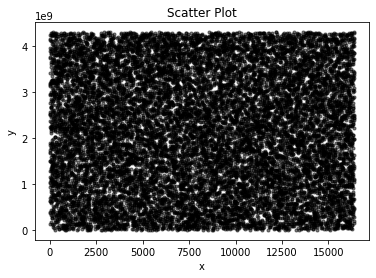

Standard Deviation:  1243364680.9080403


In [8]:
# get the second column
def takeSecond(elem):
    return elem[1]


#key generation v2 output : PRNGlist, 32-Bit sorted sorting index 
def getPRNG(a,b,c,x0,y0,p1,z0,p2):
    
    
    iLen = math.ceil(a*b*c/4)
    
    sortLength = (a//2)*(b//2)*c 
    
    t1Values = list()
    t2Values = list()
    t3Values = list()
    
    
    valueResults = list()
    xValues = list()
    
    PermutationList = list() 
    
    for iNum in range(iLen):
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        valueResults.append(res)
        t1Values.append(x0)
        t2Values.append(y0)
        t3Values.append(z0)
        
        xValues.append(iNum)
        if(iNum < sortLength):
            PermutationList.append([iNum,res])
        
    
        
    #PermutationList.sort(key = takeSecond)
    dataPoints = iLen
    x = xValues
    y = valueResults
    colors = (0,0,0)
    area = np.pi*3

#     Plot
    plt.scatter(x, y, s=area, c=colors, alpha=0.5)
    plt.title('Scatter Plot')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    
#     plt.plot(x,y,'b-.')
#     plt.xlabel("i")
#     plt.ylabel("Res")
#     plt.show()
        
    
    xMean = np.mean(valueResults)
    sdRes = statistics.stdev(valueResults)
#     xMedian = np.median(valueResults)
#     xMode = multimode(valueResults)
    print("Standard Deviation: ", sdRes)
    
#     x0Mean = np.mean(t1Values)
#     xMedian = np.median(t1Values)
#     xMode = multimode(t1Values)
#     print("\n\nx0 =Mean =",xMean, " Median = ", xMedian, " Mode = ", str(xMode))
    
#     y0Mean = np.mean(t2Values)
#     yMedian = np.median(t2Values)
#     yMode = multimode(t2Values)
#     print("\n\ny0 =Mean =",yMean, " Median = ", yMedian, " Mode = ", str(yMode))
    
#     z0Mean = np.mean(t3Values)
#     zMedian = np.median(t3Values)
#     zMode = multimode(t3Values)
#     print("\n\nx0 =Mean =",zMean, " Median = ", zMedian, " Mode = ", str(zMode))
    
#     print('xmean = ',x0Mean,'ymean = ',y0Mean,'zmean = ',z0Mean)
#     print("Min = ", min(valueResults), " Max = ", max(valueResults))
    
#     counter=collections.Counter(valueResults)
#     xC = counter.keys()
#     yC = counter.values()
#     plt.plot(xC,yC,'b-.')
#     plt.show()
    return PermutationList,x0,y0,z0, valueResults


# keyList = [mKey1, mKey2, mKey3]

    
x0,y0,p1,z0,p2 = getParas(originalKey)
PermutationList, x0,y0,z0, values = getPRNG(256,256,1,x0,y0,p1,z0,p2)
        

              
            
    

#If at any state, we get any
# print(validateKey(originalKey))